In [1]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *

# Initialize a spark session
MAX_MEMORY = '15G'
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatduration', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

# Load data set into pyspark data frame 
filename_data = '../datasets/endomondoHR.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

24/09/22 17:42:03 WARN Utils: Your hostname, hanair.local resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
24/09/22 17:42:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/22 17:42:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/22 17:42:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [2]:
from datetime import *
from pyspark.sql.functions import udf, hour

# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return [time_dif.seconds/60]

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, ArrayType(elementType=FloatType()))

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

df.select('sport','timestamp','date_time', 'workout_start_time', 'duration').limit(5).toPandas()


,sport,timestamp,date_time,workout_start_time,duration
0,bike,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 16:45:46, 2014-08-24 16:45:54, 201...",16,[126.48332977294922]
1,bike,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 20:41:22, 2014-08-16 20:41:27, 201...",20,[74.0]
2,bike,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 15:47:39, 2014-08-12 15:47:46, 201...",15,[112.48332977294922]
3,bike,"[1407432042, 1407432048, 1407432056, 140743206...","[2014-08-07 17:20:42, 2014-08-07 17:20:48, 201...",17,[75.31666564941406]
4,bike (transport),"[1406909434, 1406909436, 1406909437, 140690943...","[2014-08-01 16:10:34, 2014-08-01 16:10:36, 201...",16,[22.616666793823242]


In [4]:
def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

sport_record_rdd = df.select('sport', 'duration').rdd.map(tuple).combineByKey(to_list, extend, extend).persist()
sport_record_rdd.first()

('squash', [65.30000305175781])

In [5]:
import statistics as stats
import numpy as np
import pandas as pd

def calculate_stats(x,column_name, stat_list):
    sport, duration_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(duration_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(duration_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(duration_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        if len(duration_list) == 1:
            std_stat = 0
        else:
            std_stat = stats.stdev(duration_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(duration_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(duration_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(duration_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(duration_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
                     '75th percentile', '95th percentile', 'max', 'stdev']

record_statistic_df = pd.DataFrame(sport_record_rdd.map(
        lambda x: calculate_stats(x, 'duration',stat_list)).collect())

# Set proper dataframe column orders
columns_order = ['sport'] + [stat + ' ' + 'duration' for stat in stat_list]
# Re order columns
result = record_statistic_df[columns_order]

In [6]:
result.head()

,sport,min duration,25th percentile duration,mean duration,50th percentile duration,75th percentile duration,95th percentile duration,max duration,stdev duration
0,squash,65.300003,65.300003,65.300003,65.300003,65.300003,65.300003,65.300003,0.000000
1,circuit training,0.000000,28.062500,50.947630,54.725000,65.575003,97.025836,151.633331,28.832396
2,climbing,99.500000,124.379169,230.897227,163.825005,191.370838,532.833344,646.450012,206.942231
3,martial arts,58.183334,65.050003,88.026668,86.650002,107.349998,119.790001,122.900002,27.431676
4,cross-country skiing,0.650000,61.616665,104.597717,88.949997,130.899994,237.743335,528.400024,68.344224



Summarize statistics of duration sport:


/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_1334/1793664718.py:18: FutureWarning: The provided callable <function mean at 0x10f0656c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .groupby(['sport']).agg(np.mean).plot(
/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_1334/1793664718.py:18: FutureWarning: The provided callable <function mean at 0x10f0656c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .groupby(['sport']).agg(np.mean).plot(
/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_1334/1793664718.py:18: FutureWarning: The provided callable <function mean at 0x10f0656c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. 

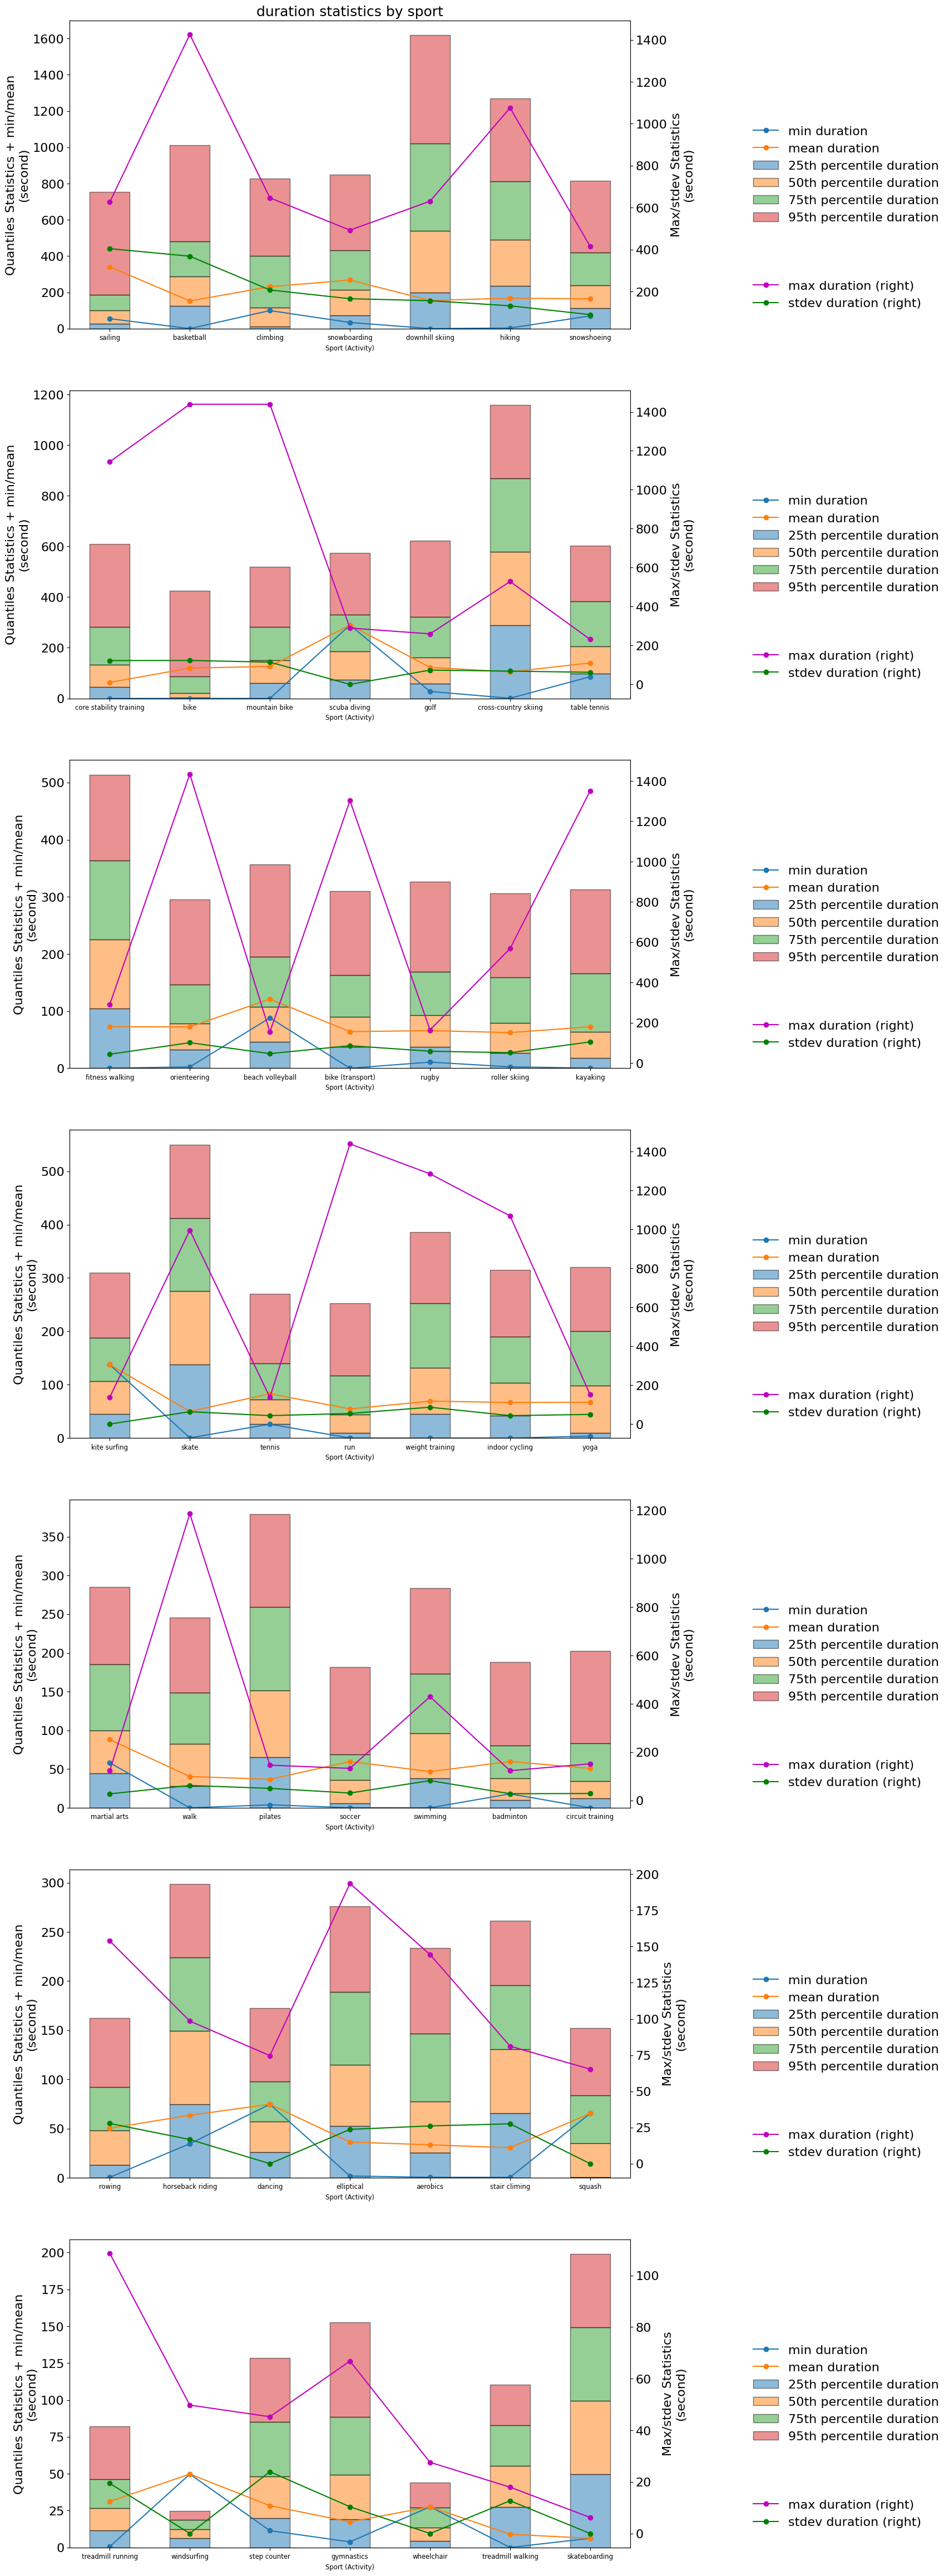

In [7]:
import matplotlib.pyplot as plt

print('\nSummarize statistics of duration sport:')
bar_columns = ['25th percentile duration', '50th percentile duration'
               , '75th percentile duration', '95th percentile duration']
line_columns1 = ['min duration', 'mean duration'] 
line_columns2 = ['max duration', 'stdev duration'] 
duration_statistic_df = record_statistic_df[columns_order].sort_values(
    by='95th percentile duration', ascending=False
)
figsize=(13, 59)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title('duration statistics by sport', fontsize=18)
for i in range (7):
    duration_statistic_sub_df = duration_statistic_df.iloc[i*7:i*7+7,]
    plot1 = duration_statistic_sub_df[['sport'] + bar_columns] \
        .groupby(['sport']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = duration_statistic_sub_df[['sport'] + line_columns1].plot(x='sport', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = duration_statistic_sub_df[['sport'] + line_columns2].plot( x='sport', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max duration (right)', 'stdev duration (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(duration_statistic_sub_df['sport'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Sport (Activity)', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(second)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(second)', fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label1.set_fontsize(16) 
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)

plt.show()

In [8]:
spark.stop()